In [1]:
## Script Index: S9
## Author: Liu Yue
## Date: 15/10/2016
## Python Version: Anaconda 4.2.0, python 3.5

""" 
    This script runs model for devce model prioritization, 
    by checking the best cut-off for device_id_count 
    with RMSE for only measuring top device models, 
    using results from S8, with 4 attributes  
"""

""" Methods """
import math
import heapq
from scipy import spatial

def merge_device_models(lst):
    """ Method to check device models with the same attributes and merge"""
    for line in lst:
        device_model_name = line[0]
        for line2 in lst:
            device_model_name2 = line2[0]
            if device_model_name!=device_model_name2 and line[1]==line2[1]:
                line[0] = device_model_name + device_model_name2
                line[2] = [line[2][0]+line2[2][0], line[2][1]+line2[2][1]]
                lst.remove(line2)
    lst = sorted(lst, key=lambda line:line[2][0],reverse=True) 

def rmse_using_average(lst):
    squared_error_average = 0
    for line in lst:
        average = line[3][0]
        actual = line[3][1]
        squared_error_average += (average-actual)*(average-actual)
    return(math.sqrt(squared_error_average/len(lst)))

def append_installation_rate(lst):
    """ Method to add average and actual installation rate"""
    for line in lst:
        installation_rate = line[2][1]/line[2][0]
        line.append([round(standard_rate,3),round(installation_rate,3)])

def similarity_computation(lst):
    """ Compute all similarity for all divice models """
    sim_mat = []
    for line in lst:
        sim_line = []
        for line2 in lst:
            sim = 1 - spatial.distance.cosine(line[1], line2[1])
            sim_line.append(sim)
        sim_mat.append(sim_line)
    return(sim_mat)


In [96]:
# Sample data
lst2[:1]

[[['小米', '红米note', '中兴', 'DM'], [5.5, 500, 4, 1], [2525, 1456]]]

Total number of devices for all device models:		 56865
Total number of devices with selected app installed:	 38291
Weighted average installation rate:			 0.673

Using 4 attributes: SCREEN SIZE, FRONT CAMERA, #CORE, RAM
Number of device models after merging:		 243


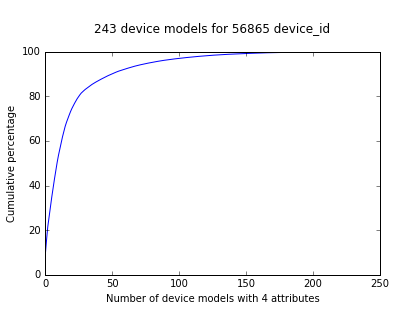

In [63]:
""" Data description"""

""" Select all 4 attributes
    With 4 attributes SCREEN SIZE, FRONT CAMERA, #CORE, RAM
    [0.309, 0.233, [7], 243, (0, 3, 4, 5)]
    243 device models after merging
"""

import csv
import copy
import math
with open('S6_device model details.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    device_model_details = list(file)
    
for line in device_model_details:
    numeric_index = {1,2,3,4,5,6,7,8,9,12,13}
    for i in numeric_index:
        line[i] = float(line[i])
        if int(str(line[i]).split('.')[1])==0:
            line[i] = int(line[i])

lst =  copy.deepcopy(device_model_details)
total_device_count = sum(line[12] for line in lst)
print("Total number of devices for all device models:\t\t",total_device_count)
total_app_device_count = sum(line[13] for line in lst)
print("Total number of devices with selected app installed:\t",total_app_device_count)
standard_rate = total_app_device_count/total_device_count
print("Weighted average installation rate:\t\t\t", round(standard_rate,3))

print("\nUsing 4 attributes: SCREEN SIZE, FRONT CAMERA, #CORE, RAM")

attribute_set = (0, 3, 4, 5)
lst2 = [[line[10:12]]+[[line[i+1] for i in attribute_set]]+[line[12:14]] for line in lst]
lst2 = sorted(lst2, key=lambda line:line[2][0],reverse=True)
merge_device_models(lst2)
print("Number of device models after merging:\t\t",len(lst2))


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

ar = sorted([line[2][0] for line in lst2], reverse=True)
ar.append(0)
y = np.cumsum(ar).astype("float32")
y/=y.max() #normalise to a percentage
y*=100.
x = range(0,len(ar))

plt.title("\n243 device models for 56865 device_id\n")
plt.ylabel('Cumulative percentage')
plt.xlabel('Number of device models with 4 attributes')

plt.plot(x,y)
plt.show()

In [64]:
""" list of possible devicd_id_count """
device_id_count = sorted(list(set(line[2][0] for line in lst2)), key=lambda x:x)
print("Number of possible device_id_count:",len(device_id_count))

Number of possible device_id_count: 103


In [66]:
def checking_error(lst3, prediction_index):
    """ Method to check the prediction error """
    count = 0
    squared_error_prediction = 0
    for line in lst3:
        average = line[3][0]
        actual = line[3][1]
        prediction = line[3][prediction_index+2]
        squared_error_prediction += (prediction-actual)*(prediction-actual)
        if abs(prediction-actual) < abs(average-actual):
            count+=1
    return(math.sqrt(squared_error_prediction/len(lst3)))

In [79]:
""" Only measuring top device models"""
import math
import heapq    
import copy
result =[]

for minminum_device_count in device_id_count[:101]:
    """"""
    lst3 =  copy.deepcopy(lst2)
    lst3 = [line for line in lst3 if line[2][0]>minminum_device_count]
    lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)
    
    ## Add installation rate
    append_installation_rate(lst3)
    ## Compute rmse for using average rate for prediction
    rmse_average = rmse_using_average(lst3)
    ## Compute all similarity for divice models 
    sim_mat = similarity_computation(lst3)

    prediction_index = 0
    rmse = []
    n = []

    for sim_n in range(1,30):  
        """ Find top n similarity """
        sim_val = [heapq.nlargest(sim_n+1, line) for line in sim_mat]
        sim_val = [line[1:] for line in sim_val]

        ## Get assignmed index of top N similar device model
        sim_name = []
        for i in range(0, len(sim_val)):
            sim_name.append([lst3[k][0] for k, j in enumerate(sim_mat[i]) if j in sim_val[i]])

        for i in range(0, len(lst3)):
            line = lst3[i]
            names = sim_name[i]
            vals = sim_val[i]
            id_count_sum = 0
            id_count_with_app = 0
            for line2 in lst3:       
                if line2[0] in names:            
                    id_count_sum += line2[2][0]
                    id_count_with_app += line2[2][1]
            line[3].append(round(id_count_with_app/id_count_sum,3))    
        n.append(sim_n)
        rmse.append(checking_error(lst3, prediction_index))
        prediction_index+=1
        
    rmse_min = round(min(rmse),3),
    n_rmse_min = [n[i] for i, j in enumerate(rmse) if j == min(rmse)]

    result.append([minminum_device_count,rmse_average,rmse_min,n_rmse_min])

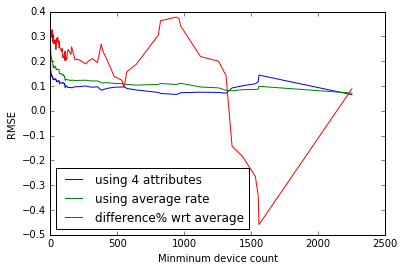

Minimum RMSE using all attributes to predict is 0.065 when device count > 2251 for predicting using most [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] similar models

RMSE of using all attributes to predict differs the most from RMSE of using average rate to predict when device count > 940 for predicting using most [1] similar models
RMSE is reduces from 0.106 to 0.066


In [80]:
"""plot Minimum RMSE vs minminum_device_count"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('Minminum device count')

legend = ["using 4 attributes","using average rate","difference% wrt average"]
n = [line[3] for line in result]
rmse_average = [line[1] for line in result]
rmse_attributes = [line[2][0] for line in result]
rmse_percentage_difference = [(line[1]-line[2][0])/line[1] for line in result]
minminum_device_count = [line[0] for line in result]
plt.plot(minminum_device_count, rmse_attributes)
plt.plot(minminum_device_count, rmse_average)
plt.plot(minminum_device_count, rmse_percentage_difference)

plt.legend(legend, loc='lower left')
plt.show()
print("Minimum RMSE using all attributes to predict is",round(min(rmse_attributes),3), 
      "when device count >", [minminum_device_count[i] for i, j in enumerate(rmse_attributes) if j == min(rmse_attributes)][0],
      "for predicting using most", [n[i] for i, j in enumerate(rmse_attributes) if j == min(rmse_attributes)][0],"similar models")
print("\nRMSE of using all attributes to predict differs the most from RMSE of using average rate to predict",
      "when device count >", [minminum_device_count[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],
      "for predicting using most", [n[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],
      "similar models\nRMSE is reduces from", 
      round([rmse_average[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0],3),
     "to", [rmse_attributes[i] for i, j in enumerate(rmse_percentage_difference) if j == max(rmse_percentage_difference)][0])

In [93]:
print("For min RMSE, number of top device models considered:",len([line for line in lst2 if line[2][0]>940]))
print("Percentage of device_id accounted for:", round(sum([line[2][0] for line in lst2 if line[2][0]>940])/56865,3))

For min RMSE, number of top device models considered: 13
Percentage of device_id accounted for: 0.36


In [94]:
## The 13 device models
[line for line in lst2 if line[2][0]>940]

[[['小米', '红米note', '中兴', 'DM'], [5.5, 500, 4, 1], [2525, 1456]],
 [['小米', 'MI 4', '一加', 'X'], [5, 800, 4, 3], [2251, 1826]],
 [['三星', 'Galaxy Note 3'], [5.7, 200, 4, 3], [1530, 1152]],
 [['华为', '荣耀6', '海信', '金刚II'], [5, 500, 8, 3], [1552, 1169]],
 [['小米', 'MI 3', '努比亚', 'Z5'], [5, 200, 4, 2], [2671, 1715]],
 [['华为', 'Mate 7', '金立', 'M5 Plus'], [6, 500, 8, 3], [1311, 1077]],
 [['华为', '荣耀6 Plus', '朵唯', 'L5 Plus'], [5.5, 800, 8, 3], [1436, 1028]],
 [['小米', 'MI 2S', '索尼', 'Xperia Z1 炫彩版'], [4.3, 200, 4, 2], [1255, 690]],
 [['小米', '红米2', '小米', '红米2A'], [4.7, 200, 4, 2], [1557, 987]],
 [['小米', '小米note', '小米', 'note顶配版'], [5.7, 400, 8, 4], [1121, 988]],
 [['OPPO', 'R7', '努比亚', 'Z9 mini 精英版'], [5, 800, 8, 3], [972, 747]],
 [['华为', '荣耀7', '努比亚', 'My 布拉格'], [5.2, 800, 8, 3], [1356, 1044]],
 [['三星', 'Galaxy S5', '魅族', 'MX3'], [5.1, 200, 4, 2], [960, 686]]]